In [41]:
# -*- coding:utf-8 -*-
# 首先加载必用的库
import tensorflow as tf
import numpy as np
# import gensim  用来加载预训练word vector
from gensim.models import KeyedVectors
import jieba
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings("ignore")

In [42]:
# 使用gensim加载预训练中文分词embedding, 有可能需要等待1-2分钟
cn_model = KeyedVectors.load_word2vec_format('../embeddings/sgns.zhihu.bigram',binary=False, unicode_errors="ignore")

W0711 09:22:22.198410 11076 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0711 09:22:28.176425 11076 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0711 09:22:38.845897 11076 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0711 09:22:47.449893 11076 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0711 09:22:50.208518 11076 utils_any2vec.py:185] duplicate word '----------------------------------

W0711 09:22:57.300556 11076 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0711 09:22:57.311525 11076 utils_any2vec.py:185] duplicate word '..................................................................................................' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0711 09:22:57.314517 11076 utils_any2vec.py:185] duplicate word '--------------------------------------------------------------------------------------------------' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0711 09:22:57.323494 11076 utils_any2vec.py:185] duplicate word '..................................................................................................' in ../embeddings/sgns.zhihu.bigram, ignoring all but first
W0711 09:22:57.324491 11076 utils_any2vec.py:185] duplicate word '----------------------------------

In [43]:
# 由此可见每一个词都对应一个长度为300的向量
embedding_dim = cn_model['山东大学'].shape[0]
embedding_dim

300

In [44]:
# 获得样本的索引
import pandas as pd

data_neg = pd.read_excel('../data/neg.xlsx', usecols=[1])
data_pos = pd.read_excel('../data/pos.xls', usecols=[0])

print('样本总数：'+str(len(data_pos) + len(data_neg)))

样本总数：7975


In [45]:
# 将所有的评价内容放置到一个list里
train_texts_orig = []
# 文本所对应的labels，也就是标记
train_target = []

for indexs in data_neg.index:
    train_texts_orig.append(data_neg.loc[indexs].values[0])
    train_target.append("0")

for indexs in data_pos.index:
    train_texts_orig.append(data_pos.loc[indexs].values[0])
    train_target.append("1")

In [46]:
print(len(train_texts_orig))
# print(train_target)
train_texts_orig

7975


['做为一本声名在外的流行书，说的还是广州的外企，按道理应该和我的生存环境差不多啊。但是一看之下，才发现相去甚远。这也就算了，还发现其中的很多规则有很强的企业个性，也就说，只是个例，而不是行例。给我们这些老油条看看也就算了，如果给那些对外企向往，或者想了解的freshman来看，实在是容易误导他们。',
 '作者有明显的自恋倾向，只有有老公养不上班的太太们才能像她那样生活。很多方法都不实用，还有抄袭嫌疑，没意思，没买的可以省省了。',
 '作者完全是以一个过来的自认为是成功者的角度去写这个问题，感觉很不客观。虽然不是很喜欢，但是，有不少的观点还是可取的。',
 '作者提倡内调，不信任化妆品，这点赞同。但是所列举的方法太麻烦，配料也不好找。不是太实用。',
 '作者的文笔一般，观点也是和市面上的同类书大同小异，不推荐读者购买。',
 '作者的文笔还行，但通篇感觉太琐碎，有点文人的无病呻吟。自由主义者。作者的品性不敢苟同，无民族立场（可谓之汉奸），风流成性',
 '作者倒是个很小资的人,但有点自恋的感觉,书并没有什么大帮助',
 '作为一本描写过去年代感情生活的小说，作者明显生活经验不足，并且文字功底极其一般，看后感觉浪费时间，不值得看，也不推荐。张贤亮，梁晓声等写作大家叙述的过去时光似乎更让人怀念和感慨，此书明显不是一个档次的。',
 '作为个人经验在网上谈谈可以，但拿来出书就有点过了，书中还有些明显的谬误。不过文笔还不错，建议写写散文好了。',
 '昨天刚兴奋地写了评论,今天便遇一闹心事,因把此套书推荐给很多朋友,朋友就拖我在网上购,结果前天购了三套,送货倒挺快,可只给了三本1,没有2,为什么一张订单上的货不全还发呢?已发了退货申请,但不知能否退,其实并不想退,只想买全,可打电话询问两次,一次说有货,让再下订单,一次答复说没货,别下订单,这可怎么办呢?我在当当上物多次,还没遇到过这种情况,答复的人说是因为网页更新慢,怎么会这么慢呢?',
 '昨天打开书才翻了几页，书页纷纷掉落了，请问怎么回事？',
 '最近下单号为：1442083355，其中一套书《易经的智慧》当当网  少带光盘 。为了得到解决，我去信两次，二三天无人回复。  然后我打电话[08/1/04 1:30]010-51236699客服热线，分机为3037。反映情况。当当网的回复令人失望，让我把书全面寄回去

In [47]:
# 使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [48]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有7909个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（） ]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)

In [49]:
# 获得所有tokens的长度
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
print("num_tokens:",num_tokens)
# print(train_tokens)
len(train_tokens)
print(len(num_tokens))

num_tokens: [76 34 33 ...  4  2  3]
7975


In [50]:
# 平均tokens的长度
print(np.mean(num_tokens))

69.44626959247648


In [51]:
# 最长的评价tokens的长度
print(np.max(num_tokens))

1540


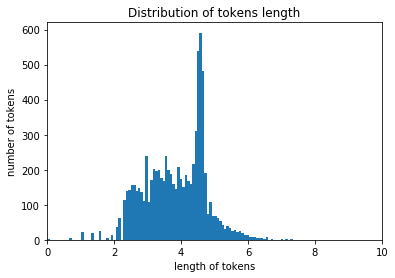

In [52]:
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [53]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

220

In [54]:
# 取tokens的长度为223时，大约96%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9678996865203762

In [55]:
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [56]:
cn_model.index2word[120]

'再'

In [57]:
train_tokens[0]

[59,
 69,
 0,
 154664,
 1,
 2010,
 473,
 16,
 1,
 57,
 2537,
 1,
 11119,
 649,
 1305,
 144,
 5,
 6,
 1,
 19945,
 869,
 90,
 86,
 197235,
 126,
 155,
 39283,
 22,
 18,
 711,
 3,
 40,
 155,
 574,
 1,
 87,
 1946,
 8,
 34,
 655,
 1,
 644,
 4253,
 18,
 38,
 16,
 143,
 13176,
 78,
 49,
 0,
 51,
 27,
 135,
 29865,
 391,
 18,
 711,
 3,
 91,
 51,
 202,
 39,
 11119,
 4862,
 122,
 62,
 441,
 1,
 188009,
 691,
 613,
 4,
 374,
 7294,
 79]

In [58]:
reverse = reverse_tokens(train_tokens[0])
reverse

'做为 声名在外的流行书说的还是广州的外企按道理应该和我的生存环境差不多啊但是一看之下才发现相去甚远这也就算了还发现其中的很多规则有很强的企业个性也就说只是个例而不是 给我们这些老油条看看也就算了如果给那些对外企向往或者想了解的freshman来看实在是容易误导他们'

In [59]:
# 只使用前50000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')
embedding_matrix

array([[-8.017840e-01, -1.653400e-01,  3.050800e-02, ...,  1.065250e-01,
         5.534360e-01,  4.366500e-01],
       [-6.517470e-01,  5.359700e-01,  3.402710e-01, ...,  8.053990e-01,
         1.045930e-01,  1.936940e-01],
       [-4.123210e-01,  2.282610e-01,  2.071140e-01, ...,  8.087770e-01,
         5.675100e-02,  4.523740e-01],
       ...,
       [ 5.849840e-01,  1.121180e-01, -6.938330e-01, ..., -3.760570e-01,
         1.203500e-01, -1.059511e+00],
       [ 1.511710e-01, -3.200000e-04, -3.885760e-01, ..., -5.988550e-01,
         4.273530e-01, -3.922630e-01],
       [-4.536090e-01, -1.813600e-02, -1.306600e-01, ..., -6.608000e-02,
         3.566680e-01,  3.898050e-01]], dtype=float32)

In [61]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum(cn_model[cn_model.index2word[30]] == embedding_matrix[30])

300

In [62]:
# embedding_matrix的维度，
# 这个维度为keras的要求，后续会在模型中用到
print("embedding_matrix.shape", embedding_matrix.shape)

embedding_matrix.shape (50000, 300)


In [63]:
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens, padding='pre', truncating='pre')
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [64]:
# 超出五万个词向量的词用0代替
train_pad[train_pad >= num_words] = 0

In [65]:
# 可见padding之后前面的tokens全变成0，文本在最后面
print("train_pad[33]", train_pad[33])

train_pad[33] [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0 

In [66]:
# 准备target向量
train_target = np.array(train_target)
train_target

array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U1')

In [67]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [68]:
# 90%的样本用来训练，剩余10%用来测试
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=0.15, random_state=1000)

In [69]:
# 查看训练样本，确认无误
print(reverse_tokens(X_train[30]))
print('class: ', y_train[30])

                                                                                                                          之前是看过推荐才想到要买拿到 先 大致看了一下除了觉得画面十分精美之外看不懂什么意思我当时还颇有些失落在下班的车上我又细细看了 部分才“恍然大悟”每次 时都要看看 要不然理解不上去惭愧 小儿大致翻看一下说没意思于是我就引导他一起看 感觉就不一样了其实只要你用心去发现就会发现 的每个小角落都是作者的精心设计很棒
class:  1


In [70]:
# 用LSTM对样本进行分类
model = Sequential()

In [71]:
# 模型第一层为embedding
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_tokens, trainable=False))

model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.1))

model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

In [72]:
# 我们使用adam以0.001的learning rate进行优化
optimizer = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['accuracy'])

In [73]:
# 我们来看一下模型的结构，一共90k左右可训练的变量
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 220, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 220, 128)          186880    
_________________________________________________________________
dropout_2 (Dropout)          (None, 220, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 15,196,177
Trainable params: 196,177
Non-trainable params: 15,000,000
____________________________________

In [74]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint_Class2_Copy1.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)

# 尝试加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [75]:
# 定义early stoping如果3个epoch内validation loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [76]:
# 自动降低learning rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-8, patience=0, verbose=1)

In [77]:
#定义callback函数
callbacks = [
    earlystopping,
    checkpoint,
    lr_reduction
]
# callbacks = [
#     earlystopping,
#     checkpoint,
#     lr_reduction,
#     TensorBoard(
#         log_dir='logs',
#         histogram_freq=1,
#     )
# ]

In [81]:
# 开始训练
model.fit(X_train, y_train,
          validation_split=0.2,
          epochs=20,
          batch_size=128,
          callbacks=callbacks)

Train on 5422 samples, validate on 1356 samples
Epoch 1/20
5376/5422 [============================>.] - ETA: 0s - loss: 0.0999 - acc: 0.9704
Epoch 00001: val_loss improved from 0.25553 to 0.18000, saving model to sentiment_checkpoint_Class2_Copy1.keras
5422/5422 [==============================] - 126s 23ms/sample - loss: 0.1012 - acc: 0.9701 - val_loss: 0.1800 - val_acc: 0.9358
Epoch 2/20
5376/5422 [============================>.] - ETA: 1s - loss: 0.1000 - acc: 0.9725
Epoch 00002: val_loss did not improve from 0.18000

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1e-08.
5422/5422 [==============================] - 136s 25ms/sample - loss: 0.0999 - acc: 0.9723 - val_loss: 0.1800 - val_acc: 0.9358
Epoch 3/20
5376/5422 [============================>.] - ETA: 1s - loss: 0.1021 - acc: 0.9693
Epoch 00003: val_loss did not improve from 0.18000
5422/5422 [==============================] - 125s 23ms/sample - loss: 0.1016 - acc: 0.9694 - val_loss: 0.1800 - val_acc: 0.9358
Epoch 4/20

In [82]:
# 开始测试
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

1197/1197 [==============================] - 6s 5ms/sample - loss: 0.2261 - acc: 0.9173
Accuracy:91.73%


In [83]:
model.save('my_model2_9173.h5')

In [138]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens, padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价', 'output=%.2f' % coef)
    else:
        print('是一例负面评价', 'output=%.2f' % coef)

In [139]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好
是一例负面评价 output=0.04
酒店卫生条件非常不好
是一例负面评价 output=0.06
床铺非常舒适
是一例正面评价 output=0.77
房间很凉，不给开暖气
是一例负面评价 output=0.09
房间很凉爽，空调冷气很足
是一例正面评价 output=0.78
酒店环境不好，住宿体验很不好
是一例负面评价 output=0.07
房间隔音不到位
是一例负面评价 output=0.07
晚上回来发现没有打扫卫生
是一例负面评价 output=0.12
因为过节所以要我临时加钱，比团购的价格贵
是一例负面评价 output=0.06


In [140]:
text = "換了二次房间, 第一间在洗地毯(前台竟然不知!!??), 第二间房门不用钥匙就能开, 換到第三间己经不是预定的大床房....窗外还有一个蜘蛛在结网"
predict_sentiment(text)

換了二次房间, 第一间在洗地毯(前台竟然不知!!??), 第二间房门不用钥匙就能开, 換到第三间己经不是预定的大床房....窗外还有一个蜘蛛在结网
是一例负面评价 output=0.14


In [141]:
y_pred = model.predict(X_test)
# print(y_pred)
y_pred = y_pred.T[0]
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

y_actual = np.array(y_test)

In [142]:
# 找出错误分类的索引
misclassified = np.where( y_pred != y_actual )[0]

# 输出所有错误分类的索引
len(misclassified)

1

In [143]:
misclassified[0]

0

In [144]:
# 我们来找出错误分类的样本看看
idx = misclassified[0]
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                                                                                                   比较适合国内客一楼餐厅风格上有点南洋的味道
预测的分类 1
实际的分类 1


In [ ]:
idx = 1
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])